In [ ]:
'''SHAP explanation of ML input variables
'''

In [2]:
import os
# Filter out logs (additional) : 0 - all logs, 1 - INFO, 2 - WARNING, 3 - ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # or any {'0', '1', '2'}
import sys
import numpy as np
import datetime
import matplotlib.pyplot as plt

from src.data_preparation import coloc_dataset
from src.modelling import model_distri
from src.utils import tardisml_utils
from src.utils import load_Dconfig

2024-03-18 15:29:00.090061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /LUMI_CONTAINER/env1/lib:/LUMI_CONTAINER/env1/lib64:/opt/cray/pe/papi/7.0.1.1/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/.singularity.d/libs
2024-03-18 15:29:01.257675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /LUMI_CONTAINER/env1/lib:/LUMI_CONTAINER/env1/lib64:/opt/cray/pe/papi/7.0.1.1/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/.singularity.d/libs
2024-03-18 15:29:01.257876: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot 

In [3]:
# add argument to pass config file
# narg = len(sys.argv)  # number of arguments passed
# if narg > 1:
#     year = int(sys.argv[1])
#     d1 = datetime.datetime(year, 1, 1)
#     d2 = datetime.datetime(year, 12, 31)
# else:
#     d1 = datetime.datetime(1992, 1, 1)
#     d2 = datetime.datetime(1992, 1, 10)

rootdir = tardisml_utils.get_rootdir()
ifolder = 'Leo/results/distri_240313-190725/'  # config + 4 years training + CRPSC + w/ SIA w/o lon

file_dconfig = f'{rootdir}{ifolder}'

In [4]:
# --------------------------------------------------
#                 Load config and params
# --------------------------------------------------

config = load_Dconfig.DConfig(file_dconfig, verbose=1)

nfeat = config.nfeat
num_obs = config.num_obs
ml_name = config.ml_name
var_to_exclude = config.var_to_exclude

Config file found: /scratch/project_465000269/edelleo1/Leo/results/distri_240313-190725/Dconfig_sia_2018-2022.yaml


Do we need to import the whole dataset used for training?
Can we just use less data ?

In [5]:
# --------------------------------------------------
#                 Load dataset
# --------------------------------------------------

y_as_proba = False  # True
nbins = 5  # Sea ice categories of TOPAZ5

# nfeat = 15  # exclude sia + lon
# num_obs = 1000

# Load ntrain, nval, ntest
ntrain = np.load(f'{rootdir}{config.res_dir}{config.ntrain}')
nval = np.load(f'{rootdir}{config.res_dir}{config.nval}')
ntest = np.load(f'{rootdir}{config.res_dir}{config.ntest}')


# version of TOPAZ ML-corrected to use. Is best to use TOPAZ4b ? Yes but no data after 2019 for now
# fname_tp = f'{rootdir}Leo/results/lstm_230217-153340/ml/sit_gLSTM_2011_2019.nc'
# model_tp = 'LSTM'

sc_file = f'{rootdir}{config.ml_dir}ScalerMM_{nfeat}feat.pkl'  # scaler
# var_to_exclude = ['sia', 'lon']  # 
var_to_exclude = config.var_to_exclude


# go get it in config.yaml
# d1 = datetime.datetime(2018, 10, 14)
# d2 = datetime.datetime(2018, 10, 18)
# d2 = datetime.datetime(2022, 4, 30) 

d1 = config.d1
# d2 = config.d2
d2 = datetime.datetime(2018,11,20)

all_days = np.array([d1 + datetime.timedelta(days=x) for x in range((d2-d1).days + 1)])
# remove non valid days
all_days = coloc_dataset.check_valid_days(all_days)

In [6]:
print('>> date end is manually selected ! <<')

>> date end is manually selected ! <<


In [7]:
# --------------------------------------------------

ds = coloc_dataset.DatasetTrain(days=all_days, config=config, rootdir=rootdir, ml_dir=config.ml_dir, y_as_proba=y_as_proba)

ds.exclude_var(var_to_exclude=var_to_exclude)

ds.check_nan()
ds.define_dataset_split(ntrain=ntrain, nval=nval, ntest=ntest)  # <<<<<<<<<<<< GIVE NTEST, NTRAIN, NVAL
ds.assemble_dataset(scaling=True, var_to_exclude=var_to_exclude)

Importing...
	 2018-11-14
	 2018-11-15
	 2018-11-16
	 2018-11-17
	 2018-11-18
	 2018-11-19
	 2018-11-20
Variable: lon excluded
Config file updated 'nfeat': /scratch/project_465000269/edelleo1/Leo/results/distri_240313-190725/Dconfig_sia_2018-2022.yaml
Scaling data...
Scaler saved as: /scratch/project_465000269/edelleo1/Leo/results/distri_240313-190725/ml/ScalerMM_16feat_03.pkl


IndexError: index 574464 is out of bounds for axis 0 with size 13521

In [138]:
ntrain = np.sort(ds.dataset['ntrain'])[:1000]
nval = np.sort(ds.dataset['nval'])[:1000]
ntest = np.sort(ds.dataset['ntest'])[:1000]

ds.dataset['Xtrain'] = ds.X[ntrain]
ds.dataset['Xval'] = ds.X[nval]
ds.dataset['Xtest'] = ds.X[ntest]

ds.dataset['ytrain'] = ds.y[ntrain, :ds.num_obs]
ds.dataset['yval'] = ds.y[nval, :ds.num_obs]
ds.dataset['ytest'] = ds.y[ntest, :ds.num_obs]


In [16]:
# --------------------------------------------------
#                 Load ML model
# --------------------------------------------------

nbins = 5  # TOPAZ5 sea ice categories
m0 = model_distri.ModelDistri(nfeat, num_obs, nbins, rootdir, config.ml_dir)

# m0.compile_model(name='pbin')
# m0.load_model_weights(ipath=f'{rootdir}{ml_dir}', ifolder_pattern='model_weights_CRPSC')
# m0.load_model_weights(ipath=f'{rootdir}{ml_dir}', ifolder_pattern='model_weights_pbin')

m0.load_model_weights(ipath=f'{rootdir}{config.ml_dir}', ifolder_pattern=f'model_weights_{ml_name}')

2024-03-18 15:39:19.117856: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /LUMI_CONTAINER/env1/lib:/LUMI_CONTAINER/env1/lib64:/opt/cray/pe/papi/7.0.1.1/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/.singularity.d/libs
2024-03-18 15:39:19.117914: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Loading model...
Loaded: /scratch/project_465000269/edelleo1/Leo/results/distri_240313-190725/ml/model_weights_CRPSC


# Shap

In [17]:
import shap

In [ ]:
# https://shap.github.io/shap/notebooks/deep_explainer/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html

In [140]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.Explainer(m0.model, ds.dataset['Xtrain'], feature_names=ds.features) # [:100])

In [141]:
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
# shap_values = explainer.shap_values(ds.dataset['Xtrain'][:10])
shap_values = explainer(ds.dataset['Xtest'])
                                    # , nsamples=30)

PermutationExplainer explainer: 1001it [08:07,  2.01it/s]                       


In [40]:
# init the JS visualization code
shap.initjs()

In [135]:
shap_values[:,:,:].shape

(100, 16, 1000)

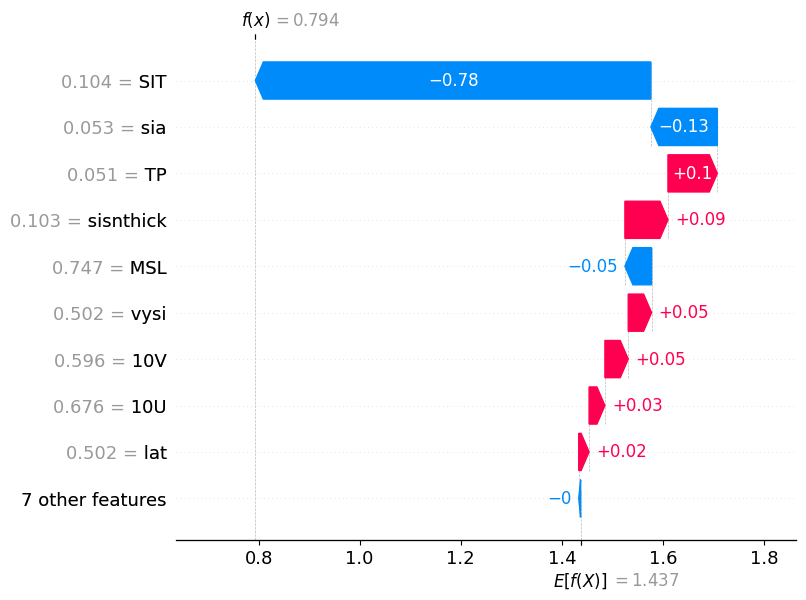

In [130]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[11,:,0])

In [131]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[11,:,0])

In [132]:
shap.plots.force(shap_values[:,:,0])

In [143]:
shap.plots.force(shap_values[:,:,0])

In [144]:
shap.plots.force(shap_values[:100,:,0])

In [136]:
shap.plots.heatmap?

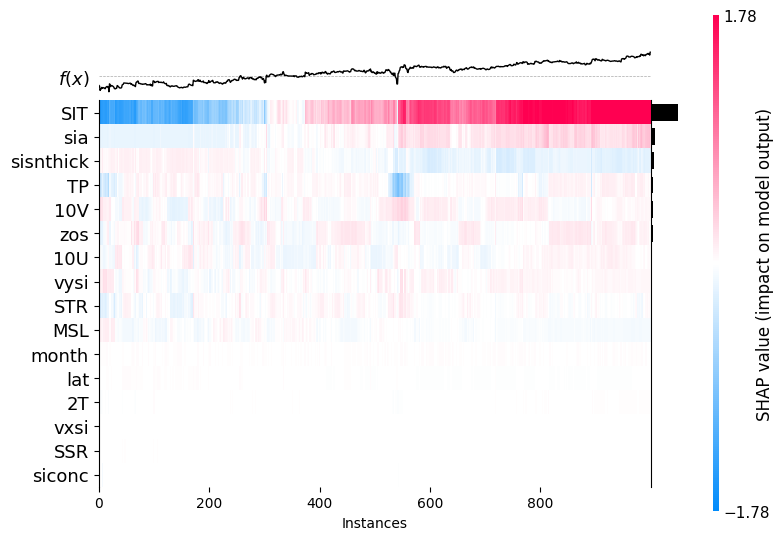

In [142]:
shap.plots.heatmap(shap_values[:,:,0], max_display=20)